# Librairies

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import scipy
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import parallel_coordinates
import graphviz 
from sklearn import tree
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score

#np.random.seed(10)
#random.seed(10)

In [2]:
df_global = pds.read_csv('./Data_Classif/Data.txt', sep="\t")

Les données comportent des champs inutiles à notre étude, et des valeurs manquantes qu'il faut trier.

## Nettoyage des lignes

Suppression des time codes et des valeurs manquantes.

In [3]:
df_global=df_global.drop(["Time","Time Code","Country Code"],axis=1)
filtered_df = df_global.dropna()
filtered_df.head()

,Country Name,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land
1,Albania,5.63382,1.749211,0.000000,77.70200,2895092.0,55.387,27400.0,4413.081697,9.0,53.652000,43.332117
7,Argentina,0.64461,4.462904,64.000402,76.08900,42539925.0,91.249,2736690.0,12976.636425,13.0,60.403000,54.518049
10,Australia,2.50737,16.083474,86.735892,82.14878,23145901.0,85.502,7682300.0,67990.290030,10.0,65.008003,51.627156
12,Azerbaijan,6.32932,3.785069,93.041877,71.65600,9416801.0,54.145,82659.0,7875.756953,10.0,64.546997,57.704545
14,Bahrain,6.26169,23.804357,100.000000,76.48200,1315411.0,88.835,770.0,24737.171783,9.0,71.518997,11.168831


Les données retenues pour l'étude sont :

- Country name : nom du pays.
- Children out of school : proportion des enfants non scolarisés parmi ceux d'âge inférieur à l'âge de scolarisaton de premier et second degré (%).
- CO2 : émissions de CO2 (tonnes/habitant).
- NR electricity : proportion d'électricité issue de sources non renouvelables et émettrices de CO2 (essence, gaz et charbon) parmi la production totale (%).
- Life expectancy : espérance de vie moyenne à la naissance (années).
- Population : population totale.
- Urban population : proportion d'urbains dans la population totale (%).
- Area : aire terrsetre du pays (km^2).
- GDP : PIB par habitant d'âge moyen (en Dollars US actuels).
- Compulsory education : durée légale minimale d'enseignement obligatoire (années).
- Labor force : proportion de personnes âgées de 15 ans et plus économiquement actives dans la population (%).
- Agricultural land : proportion du territoire utilisé pour l'agrigulture (%).

## Normalisation des données

### Centrage

On centre les données car elles sont exprimées dans des variables différentes et ont des ordres de grandeur complètement différents.

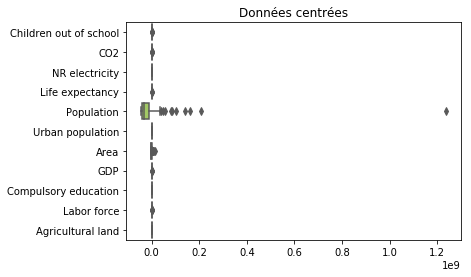

In [4]:
ax=sns.boxplot(data=(filtered_df.drop("Country Name",axis=1) - 
    filtered_df.drop("Country Name",axis=1).mean()),
    orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

Nous devons également réduire en raison de la variance élevée de la population.

### Réduction 

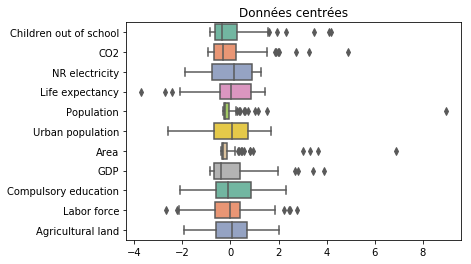

In [5]:
ax=sns.boxplot(data=((filtered_df.drop("Country Name",axis=1) 
    - filtered_df.drop("Country Name",axis=1).mean())
    /filtered_df.drop("Country Name",axis=1).std()), 
    orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

In [6]:
dfo=(filtered_df.drop("Country Name",axis=1) 
    - filtered_df.drop("Country Name",axis=1).mean()
    )/filtered_df.drop("Country Name",axis=1).std()
dfoc=dfo.copy()
dfoc["Country"]=filtered_df["Country Name"]

# Recherche des outliers

Comme précédemment nous allons chercher les outliers grâce à DBSCAN. La première étape sera donc de paramétrer ce modèle en traçant la distance pour chaque point à son 4e voisin plus proche grâce à l'algorithme des KNN.

### Définition des paramètres de DBSCAN grâce à KNN

In [7]:
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(dfo)
distances, indices = nbrs.kneighbors(dfo)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

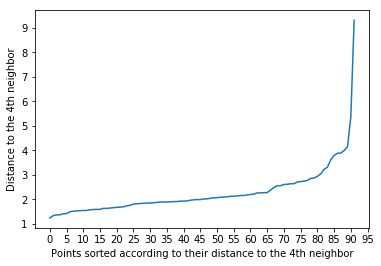

In [8]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
t=plt.ylabel('Distance to the 4th neighbor')
_=plt.xticks(np.arange(0, 100, step=5))

D'après le graphique ci-dessus on observe un coude pour les pays d'indices entre 75 et 85.

In [9]:
mean_dist_knee = sum(distances_to_4[75:85])/10
mean_dist_knee

3.0023049703042854

On considérera donc un rayon de recherche d'environs 3, et un nombre minimum de point égal à 10, pour considérer un cluster.

### Analyse des résultats de DBSCAN

In [10]:
outliers_det = DBSCAN(min_samples=6,eps=mean_dist_knee).fit(dfo)
print "Il y a",sum(outliers_det.labels_ == -1),"outliers."

Il y a 10 outliers.


In [11]:
dfol= dfo.copy(deep=True) # Copy of DF_kmeans1
dfol['Labels'] = outliers_det.labels_

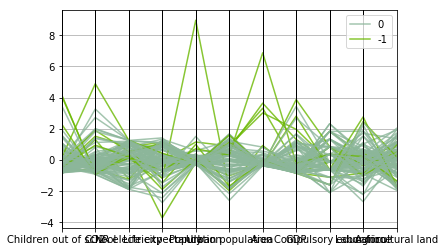

In [12]:
parallel_coordinates(dfol,'Labels', alpha=0.8)
plt.show()

In [13]:
print(dfoc["Country"][dfol['Labels'] == -1])

10              Australia
26                 Brazil
35                 Canada
47          Cote d'Ivoire
89                  India
116            Luxembourg
149              Pakistan
159                 Qatar
161    Russian Federation
191              Tanzania
Name: Country, dtype: object


Les pays ci-dessus sont les outliers.

In [14]:
dff=dfol[dfol.Labels != -1]
dff=dff.drop('Labels',axis=1)
dff["Country"]=dfoc["Country"][dfol['Labels'] != -1]
dff.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,-0.696435,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,-0.337704,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,-0.551382,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,0.154949,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,-0.547063,-0.612305,0.282584,0.115869,Belarus


Ce sont les données finales sur lesquelles on va travailler.

# Labels de classe par discrétisation

Nous allons labéliser les données à l'aide d'une étiquette de classe avec le PIB par habitant. On discrétise le PIB par habitant à l'aide d'un Kmeans. 

Pour avoir une idée du nombre de classes, on trace l'histogramme sur les données réduites.

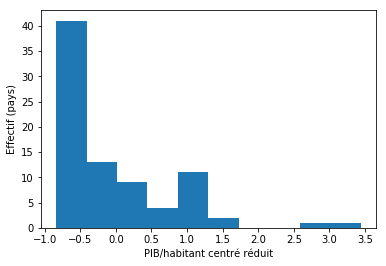

In [15]:
h=plt.hist(dff["GDP"])
plt.xlabel(u"PIB/habitant centré réduit")
plt.ylabel("Effectif (pays)")
_=plt.xticks(np.arange(-1,4,.5))

On distingue 3 classes (<0.5 / 0.5-2.5 / >2.5). 

In [16]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n,random_state=1)
    # on fixe la graine aléatoire
    km1.fit(attribute.reshape(-1,1))
    return km1

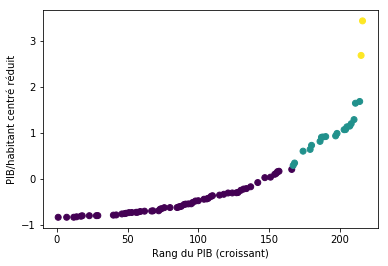

In [17]:
V_GDP  = np.array(sorted(dff['GDP']))
km_gdp = kmeans_1D(V_GDP,3)
plt.scatter(dff.index,sorted(dff['GDP']),c=km_gdp.labels_.astype(np.float))
plt.ylabel(u"PIB/habitant centré réduit")
_=plt.xlabel("Rang du PIB (croissant)")

In [18]:
dff.sort_values(by =['GDP'] , ascending = False).iloc[:2,-1]

147         Norway
188    Switzerland
Name: Country, dtype: object

On observe deux pays très riches par rapport aux autres groupes (la Norvège et la Suisse). Les limites de classes de kmeans sont proches de celles trouvées graphiquement par l'histogramme.
On décide d'exclure ces deux pays très riches de l'analyse car l'effectif de cette classe est trop faible.

On compte le nombre de labels de chaque classe.

In [19]:
unique, counts = np.unique(km_gdp.labels_, return_counts=True)
b=counts[0]-1
a=counts[0]+counts[1]-1

On associe un label à chaque PIB.
On considèrera 2 groupes :
* Les pays pauvres (B)
* Les pays riches (A)

On transforme la colonne correspondante.

In [20]:
def discretize_GDP(counts,df,vect,b,a):
    """Fonction pour discrétiser le PIB dans un dataframe à partir 
    des effectifs de classe de K-means (counts).
    Attention, le PIB doit être en colonne 7.
    Attention, il faut vérifier dans quel ordre sont les clusters 
    dans l'objet counts.
    Retourne un dataframe discrétisé dfd."""
    # Bornes des classes
    dfd=df.copy()
    i=0
    # indexes to drop
    todrop=[]
    for i in range(len(df)):
        # column 7 = GDP
        if df.iloc[i,7]<=vect[b]:
            dfd.iloc[i,7]="B"
        elif df.iloc[i,7]<=vect[a] and dff.iloc[i,7]>vect[b]:
            dfd.iloc[i,7]="A"
        elif dff.iloc[i,7]>vect[a]:
            todrop.append(dfd.index[i])
    for d in todrop:    
        dfd=dfd.drop(index=d)
    return dfd

In [21]:
dfd=discretize_GDP(counts,dff,V_GDP,b,a)
dfd.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,B,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,B,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,B,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,B,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,B,-0.612305,0.282584,0.115869,Belarus


On a un dafaframe avec le PIB discrétisé.

## Préparation des données pour la classification

In [22]:
dffea = dfd.drop(['GDP','Country'],axis=1)
classes = dfd["GDP"]
sortedLabelList = sorted(list(set(classes)))

## Arbre de décision

### Jeu d'entraiement

In [43]:
prop_tree=.22
tX_train, tX_test, ty_train, ty_test = train_test_split(dffea, classes, test_size=prop_tree, random_state=42)

In [44]:
nleaf=12
treeModel = DecisionTreeClassifier(criterion = 'entropy', random_state=20, min_samples_leaf=nleaf)
t=treeModel.fit(tX_train, ty_train)

In [45]:
tM=metrics.confusion_matrix(y_true=ty_train, y_pred=ty_train, labels=sortedLabelList)
print(tM)

[[15  0]
 [ 0 47]]


Le jeu d'entraînemet compte 15 pays de PIB A et 47 de PIB B.

In [46]:
trueLabels=['A','B']
predictLabels=['a','b']
allLabels=trueLabels+predictLabels

In [47]:
dot_data = tree.export_graphviz(t, out_file=None, 
                         feature_names=dffea.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

### Jeu test

In [48]:
ty_predict = treeModel.predict(tX_test)
print "Accurracy classique :",metrics.accuracy_score(ty_test, ty_predict)
print u"Accurracy pondérée :",balanced_accuracy_score(ty_test, ty_predict)

Accurracy classique : 1.0
Accurracy pondérée : 1.0


On choisit pour cette étude d'utiliser l'accuracy pondérée car les classes ont des effectifs très différents.

Les deux métriques ne donnent pas exactement les mêmes chiffres : en effet, l'accurracy classique attribue un coût plus élevé pour une mauvaise classification dans la classe de PIB B (grande), alors que l'accurracy pondérée prend en compte la taille de la classe cible.

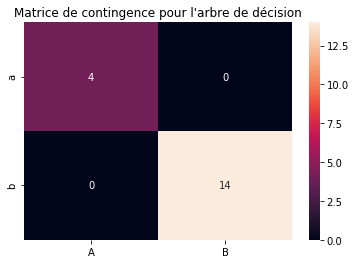

In [49]:
tMP=metrics.confusion_matrix(y_true=ty_test, y_pred=ty_predict, labels=sortedLabelList)
tmdfp = pds.DataFrame(data=tMP, copy=True, index=trueLabels, columns=predictLabels)
tmdfp = tmdfp.transpose()
ax=sns.heatmap(tmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour l'arbre de décision")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [33]:
print metrics.classification_report(ty_test, ty_predict)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Pour la classe A, le rappel est meilleur que la précision. En effet, il y a moins de faux négatifs que de faux positifs (0 contre 1). Pour la classe B, la précision est meilleure (1 faux positif et 0 faux négatif).

Le f1-score de la classe B est meilleur : en prenant en compte les faux positifs et les faux négatifs, la classe B est donc mieux prédite.

En ce qui concerne l'évaluation du modèle globale, on considère la moyenne pondérée (weighted avg) car les classes ont des effectifs très différents. La précision, le rappel et le f1-scort sont du même ordre de grandeur (0,94) : le modèle est très bon.

## K plus proches voisins

In [34]:
prop_k=.2
kX_train, kX_test, ky_train, ky_test = train_test_split(dffea, classes, test_size=prop_k, random_state=42)

nneighbors=6
knnModel = neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)
knnModel.fit(kX_train, ky_train)
kM=metrics.confusion_matrix(y_true=ky_train, y_pred=ky_train, labels=sortedLabelList)
print(kM)

[[15  0]
 [ 0 49]]


In [35]:
ky_predict = knnModel.predict(kX_test)
print "Accurracy classique :",metrics.accuracy_score(ky_test, ky_predict)
print u"Accurracy pondérée :",balanced_accuracy_score(ky_test, ky_predict)

Accurracy classique : 1.0
Accurracy pondérée : 1.0


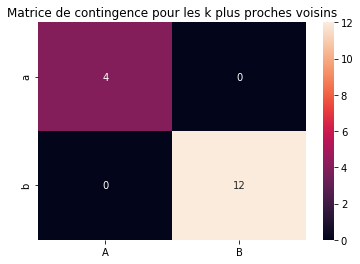

In [36]:
kMP=metrics.confusion_matrix(y_true=ky_test, y_pred=ky_predict, labels=sortedLabelList)
kmdfp = pds.DataFrame(data=kMP, copy=True, index=trueLabels, columns=predictLabels)
kmdfp = kmdfp.transpose()
ax=sns.heatmap(kmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour les k plus proches voisins")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [37]:
print metrics.classification_report(ky_test, ky_predict)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



Ici, le modèle a parfaitement prédit toutes les classes. La précision, le rappel et le f1-score sont maximaux.

## Détection de sur-apprentissage

In [38]:
def plotErrorTest(step,dffeatures,classes,m,start=.01,stop=.99):
    """Trace le pourcentage d'erreur du modèle en fonction de la taille de la classe test.
    step est le pas d'incrémentation de la proportion de classe test.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    model est le modèle de classificaton (t pour un arbre de décision, k pour les k plus 
    proches voisins).
    start et stop sont les proportions de départ et d'arrivée du jeu test."""
    if m=="k":
        model=neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)
    prop=np.arange(start,stop,step)
    error=np.ndarray(len(prop))
    i=0
    for p in prop:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # on fixe la graine aléatoire mais elle est différente à chaque itération
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=p,random_state=k)
            #train
            # 2 cas en fonction du modèle
            if m=='t':
                #la graine aléatoire est différente à chaque itération
                model = DecisionTreeClassifier(criterion = 'entropy', 
                    random_state=k, min_samples_leaf=nleaf)
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(prop,error)
    plt.xlabel("Proportion du jeu test")
    plt.ylabel(u"Taux d'erreur (%)")
    if m=='k':
        plt.title(u"K plus proches voisins")
    elif m=='t':
        plt.title(u"Arbre de décision")

In [39]:
def plotErrorLeaf(dffeatures,classes,start=1,stop=50):
    """Trace le pourcentage d'erreur du modèle en fonction du nombre minimal 
    d'objets pour faire une feuille.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    start et stop sont la taille de départ et d'arrivée de la feuille."""
    leaf=np.arange(start,stop)
    error=np.ndarray(len(leaf))
    i=0
    for l in leaf:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # on fait une moyenne sur plusieurs jeux de test/d'entraînement
            model = DecisionTreeClassifier(criterion = 'entropy', 
                random_state=k, min_samples_leaf=l)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=prop_tree,random_state=k)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(leaf,error)
    plt.xlabel("Nombre minimal d'objets dans un noeud")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(u"Arbre de décision")

In [40]:
def plotErrorNeighbors(dffeatures,classes,start=1,stop=50):
    """Trace le pourcentage d'erreur du modèle en fonction du nombre 
    de voisins utilisé.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    start et stop sont le nombre de voisins de départ et d'arrivée."""
    neighb=np.arange(start,stop)
    error=np.ndarray(len(neighb))
    i=0
    for n in neighb:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # On fait une moyenne car l'arbre de décision est aléatoire
            # On change aussi le jeu de test/d'entraînement
            model = neighbors.KNeighborsClassifier(n_neighbors=n, weights='uniform', p=2)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=prop_k,random_state=k)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(neighb,error)
    plt.xlabel("Nombre de voisins")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(u"K plus proches voisins")

### Erreur en fonction de la proportion du jeu test

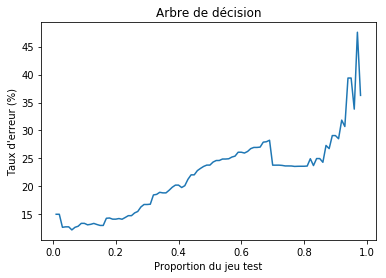

In [40]:
plotErrorTest(.01,dffea,classes,'t')

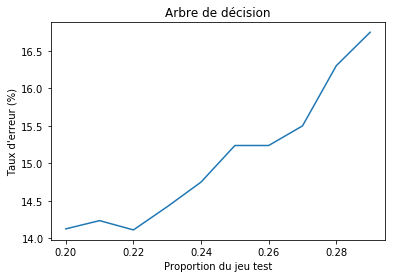

In [42]:
plotErrorTest(.01,dffea,classes,'t',.2,.3)

L'erreur augmente avec la proportion de jeu test. En effet, plus cette proportion est grande et moins le modèle a pu s'entraîner. Cependant, cela n'a aucun sens de choisir un jeu test trop petit (surtout dans notre cas où cela correspondrait à deux ou trois objets).

On choisira une proportion de test de 0,22.

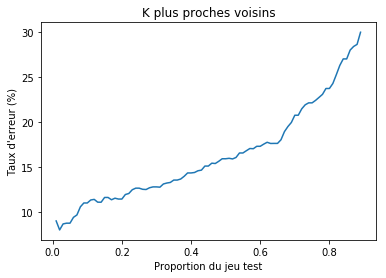

In [44]:
plotErrorTest(.01,dffea,classes,'k',.01,.9)

De même, on choisit une proportion de test de 0,2. 

On remarque que l'erreur associée à l'arbre de décision augmente plus vite que l'erreur associée aux k plus proches voisins.

### Erreur en fonction du nombre minimal d'items pour donner une feuille (arbre de décision)

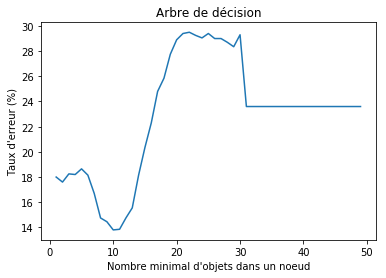

In [45]:
plotErrorLeaf(dffea,classes,1,50)

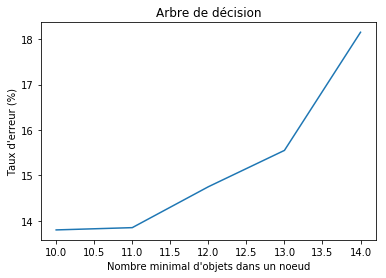

In [46]:
plotErrorLeaf(dffea,classes,10,15)

Le nombre d'objets optimal dans un noeud semble être de 12. En dessous, il y a trop de feuiles et il y a sur-apprentissage. Au dessus, le modèle est trop simple.

### Erreur en fonction du nombre de voisins (knn)

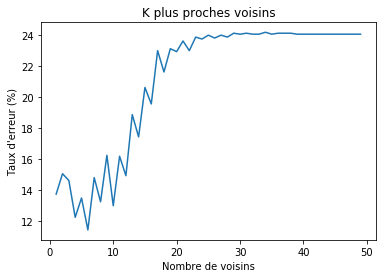

In [75]:
plotErrorNeighbors(dffea,classes,1,50)

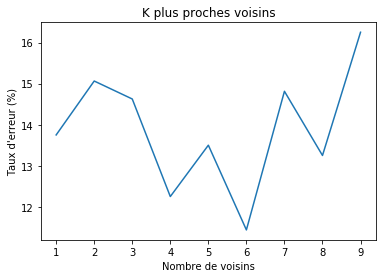

In [83]:
plotErrorNeighbors(dffea,classes,1,10)

Si l'algorithme ne considère pas assez de voisins, les résultats sont mauvais car l'apprentissage est trop spécifique (par exemple, s'il y a du bruit un point peut-être classifié comme un voisin proche mais dû au bruit). S'il considère trop de voisins, les classes sont trop générales et donc mal définies.
Le nombre de voisins optimal semble être 6.

## Comparaison des deux méthodes de classification

### Accurracy

Comme l'arbre de décision est une méthode aléatoire et qu'on peut tester plusieurs jeux test/entraînement, on considère un score d'accurracy moyen sur plusieurs runs.

In [54]:
# Arbre de décision
n=100
taccurracy=np.ndarray(n)
for i in range(n):
    tX_train2, tX_test2, ty_train2, ty_test2 = train_test_split(dffea, classes, test_size=prop_tree, random_state=i)
    model2 = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=nleaf)
    tr=model2.fit(tX_train2, ty_train2)
    ty_predict2 = model2.predict(tX_test2)
    taccurracy[i]=metrics.balanced_accuracy_score(ty_test2, ty_predict2)
meanAccurracyTree=np.mean(taccurracy)

/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Pour les k plus proches voisins, on considère également un score d'accurracy moyen sur plusieurs pour plusieurs jeux de test/entraînement.

In [58]:
# KNN
n=100
kaccurracy=np.ndarray(n)
for i in range(n):
    kX_train2, kX_test2, ky_train2, ky_test2 = train_test_split(dffea, classes, test_size=prop_k, random_state=i)
    kr=knnModel.fit(kX_train2, ky_train2)
    ky_predict2 = knnModel.predict(kX_test2)
    kaccurracy[i]=metrics.balanced_accuracy_score(ky_test2, ky_predict2)
meanAccurracyKnn=np.mean(kaccurracy)

/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [59]:
print u"Accurracy moyenne pondérée pour l'arbre de décision (",n," runs) :", meanAccurracyTree
print u"Accurracy pondérée des k plus proches voisins (",n," runs) :",meanAccurracyKnn

Accurracy moyenne pondérée pour l'arbre de décision ( 100  runs) : 0.8356128173297291
Accurracy pondérée des k plus proches voisins ( 100  runs) : 0.8817367632367633


Les scores d'accurracy sont comparables : mais l'algorithme des k plus proches voisins est plus performant.

## Précision et rappel

Par simplicité, on considère cette fois des runs uniques.

In [60]:
print "----------------------------- Arbre de décision -----------------------------\n", metrics.classification_report(ty_test, ty_predict)
print "----------------------------- k plus proches voisins -----------------------------\n", metrics.classification_report(ky_test, ky_predict)

----------------------------- Arbre de décision -----------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

----------------------------- k plus proches voisins -----------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



L'algorithme de l'arbre de décision a des meilleurs scores de précision et rappel pondérés globaux (ligne weighted avg) que les k plus proches voisins. Par conséquent, le f1-score (moyenne harmonique de précision et rappel) est également meilleur. Précisons cependant que cet algorithme est non déterministe et ses résultats peuvent donc varier d'un run à l'autre.


Cependant, il y a toujours le problème de la classe A qui est petite.

### Entropie

De même, on considère une entropie moyenne sur plusieurs runs.

In [71]:
n=100
tentrop=np.ndarray((n,2))
for i in range(n):
    tX_train2, tX_test2, ty_train2, ty_test2 = train_test_split(dffea, classes, test_size=prop_k, random_state=i)
    model2 = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=10)
    t=model2.fit(tX_train2, ty_train2)
    y_predict2 = model.predict(tX_test2)
    tMP=metrics.confusion_matrix(y_true=ty_test2, y_pred=y_predict2, labels=sortedLabelList)
    tmdfp = pds.DataFrame(data=tMP, copy=True, index=trueLabels, columns=predictLabels)
    tmdfp = tmdfp.transpose()
    tproba = tmdfp[1:][:].values/tmdfp[1:][:].values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
    tentropy = [stats.entropy(row, base=2) for row in tproba]
    tentrop[i]=tentropy
    
meanEntropy=np.sum(tentrop,axis=0)/n

In [69]:
# KNN
n=100
kentrop=np.ndarray(n)
for i in range(n):
    kX_train2, kX_test2, ky_train2, ky_test2 = train_test_split(dffea, classes, test_size=prop_k, random_state=i)
    kr=knnModel.fit(kX_train2, ky_train2)
    ky_predict2 = knnModel.predict(kX_test2)
    kMP=metrics.confusion_matrix(y_true=ky_test2, y_pred=ky_predict2, labels=sortedLabelList)
    kmdfp = pds.DataFrame(data=kMP, copy=True, index=trueLabels, columns=predictLabels)
    kmdfp = kmdfp.transpose()
    kproba = kmdfp.values/tmdfp.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
    kentropy = [stats.entropy(row, base=2) for row in tproba]
    entrop[i]=kentropy
meankEntropy=np.sum(kentrop,axis=0)/n

In [72]:
print "----------------------------- Arbre de décision -----------------------------"
print "Entropie de chaque (pour ",n," runs) :", meanEntropy
kproba = kmdfp.values/kmdfp.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
kentropy = [stats.entropy(row, base=2) for row in kproba]
print "----------------------------- k plus proches voisins -----------------------------"
print "Entropie de chaque classe :", kentropy

----------------------------- Arbre de décision -----------------------------
Entropie de chaque (pour  100  runs) : [0.20988472 0.20988472]
----------------------------- k plus proches voisins -----------------------------
Entropie de chaque classe : [0.9709505944546688, 0.43949698692151334]


L'entropie mesurée pour les deux classes est plus faible pour l'algorithme de l'arbre de décision.

**Conclusion : l'algorithme de l'arbre de décision semble plus performant pour ces données.**